In [22]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from simple_block import simple
import jacobian as jac
from het_block import het
import scipy.optimize as opt

In [23]:
@het(exogenous='Pi', policy='a', backward='Va')
def household(Va_p, Pi_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (S*A), marginal value of assets tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount rate today
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    uc_nextgrid = (beta * Pi_p) @ Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = utils.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    utils.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

In [24]:
def ks_ss(lb=0.98, ub=0.999, r=0.01, eis=1, delta=0.025, alpha=0.11, rho=0.966, sigma=0.5, nS=7, nA=500, amax=200):
    """Solve steady state of full GE model. Calibrate beta to hit target for interest rate.
    
    Parameters
    ----------
    lb    : scalar, lower bound of interval bracketing beta
    ub    : scalar, upper bound of interval bracketing beta
    r     : scalar, real interest rate
    eis   : scalar, elasticity of intertemporal substitution
    delta : scalar, depreciation rate
    alpha : scalar, capital share
    rho   : scalar, autocorrelation of income process
    sigma : scalar, cross-sectional sd of log income
    nS    : int, number of income gridpoints
    nA    : int, number of capital gridpoints
    amax  : scalar, upper bound of capital grid

    Returns
    ----------
    ss : dict, steady state values
    """
    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_s, Pi = utils.markov_rouwenhorst(rho=rho, sigma=sigma, N=nS)
    
    # solve analytically what we can
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))
    
    # initialize guess for policy function iteration
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # solve for beta
    beta_min = lb / (1 + r)
    beta_max = ub / (1 + r)
    beta, sol = opt.brentq(lambda bet: household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=bet, eis=eis,
                                                    Va=Va)['A'] - K, beta_min, beta_max, full_output=True)
    if not sol.converged:
        raise ValueError('Steady-state solver did not converge.')

    # extra evaluation for reporting
    ss = household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=beta, eis=eis, Va=Va)
    
    # check Walras's law
    walras = Y - ss['C'] - delta * K
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'w': w, 'Z': Z, 'K': K, 'L': 1, 'Y': Y, 'alpha': alpha, 'delta': delta, 'walras': walras})

    return ss

In [25]:
ss1 = ks_ss()

In [26]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def mkt_clearing(K, A):
    asset_mkt = A - K
    return asset_mkt

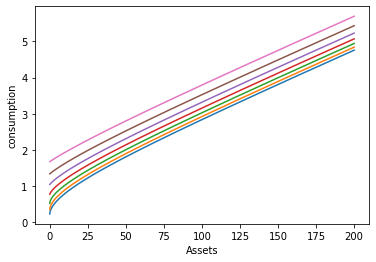

In [27]:
import matplotlib.pyplot as plt
plt.plot(ss1['a_grid'], ss1['c'].T)
plt.xlabel('Assets'), plt.ylabel('consumption')
plt.show()

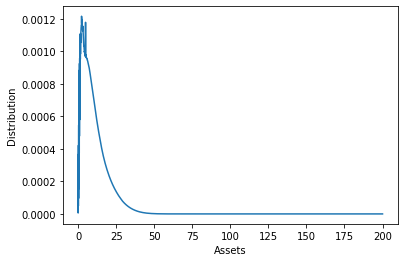

In [28]:
plt.plot(ss1['a_grid'], ss1['D'][4])
plt.xlabel('Assets'), plt.ylabel('Distribution')
plt.show()

In [29]:
T = 300
G1 = jac.get_G(block_list=[firm, mkt_clearing, household],  # we could replace household with J_ha here
               exogenous=['Z'],
               unknowns=['K'],
               targets=['asset_mkt'],
               T=T, ss=ss1)

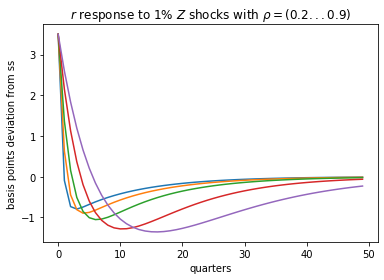

In [30]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ1 = 0.01*ss1['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G1['r']['Z'] @ dZ1
plt.plot(10000*dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'basis points deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [31]:
def rbc_ss(beta=0.99, eis=1, Z=1, delta=0.025, alpha=0.11):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    beta   : scalar, discount rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    r = 1/beta - 1
    rk = r + delta
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [32]:
@simple
def household(Y, K, L, w, eis, delta):
    I = K - (1 - delta) * K(-1)
    C = Y - I
    return C, I

@simple
def mkt_clearing(r, w, C, Y, K, L, eis, beta):
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return euler, walras

In [33]:
ss0 = rbc_ss(beta = ss1['beta'],Z = ss1['Z'])

In [34]:
G0 = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K'],
              targets=['euler'],
              T=300, ss=ss0)

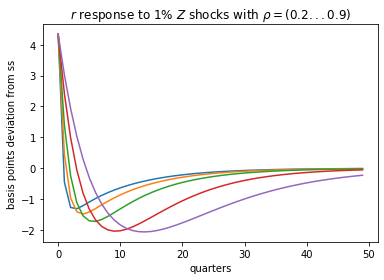

In [35]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ0 = 0.01*ss0['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G0['r']['Z'] @ dZ0
plt.plot(10000*dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'basis points deviation from ss')
plt.xlabel(r'quarters')
plt.show()

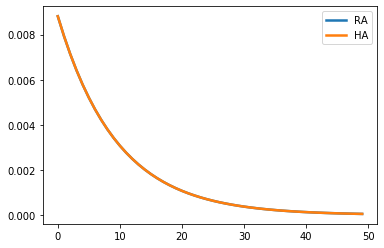

In [36]:
plt.plot(dZ0[:50, 4], label='RA', linewidth=2.5)
plt.plot(dZ1[:50, 4], label='HA', linewidth=2.5)
plt.legend()
plt.show()

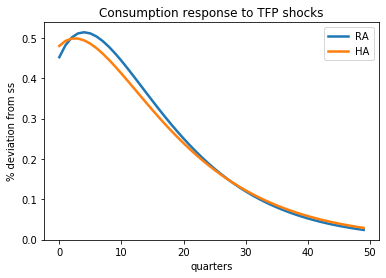

In [37]:
dC0 = 100 * G0['C']['Z'] @ dZ0 / ss0['C']
dC1 = 100 * G1['C']['Z'] @ dZ1 / ss1['C']
plt.plot(dC0[:50,4], label='RA', linewidth=2.5)
plt.plot(dC1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

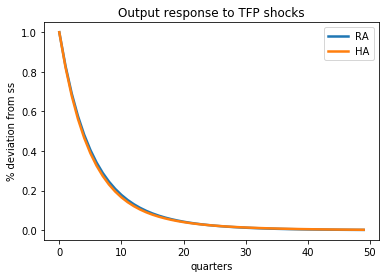

In [38]:
dY0 = 100 * G0['Y']['Z'] @ dZ0 / ss0['Y']
dY1 = 100 * G1['Y']['Z'] @ dZ1 / ss1['Y']
plt.plot(dY0[:50, 3], label='RA', linewidth=2.5)
plt.plot(dY1[:50, 3], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

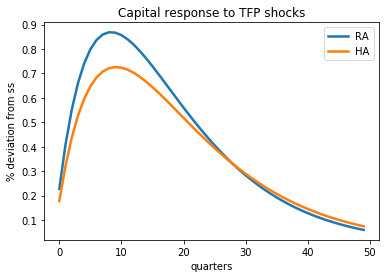

In [39]:
dK0 = 100 * G0['K']['Z'] @ dZ0 / ss0['K']
dK1 = 100 * G1['K']['Z'] @ dZ1 / ss1['K']
plt.plot(dK0[:50, 4], label='RA', linewidth=2.5)
plt.plot(dK1[:50, 4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Capital response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [42]:
[ss0['Y'],ss0['C'],ss0['K']]

[0.9738220465846438, 0.9120867182361599, 2.469413133939355]

In [43]:
[ss1['Y'],ss1['C'],ss1['K']]

[1.0, 0.9214285751609561, 3.1428571428571432]